# Skoda Auto - rides

This notebook uses Skoda rides data. The data covers movement of vehicles for work-related trips for period March to September 2019.

TODO:
- nahrat vsechny trips/postupne zprocesovat
- recordgeometry -> geometry
- recorddatetime -> datetime
- varianta 1: points to trajectry v  postgis + detectstops (A.Graser)
- varianta 2: points, adapted detectstops to add column trip, trajectory pomoci group by (carid,trip)
- vypsat statistiky (sql po inicializaci/pandas)
- poresit carid to be categorized not continuous int
- dopocitat speed (movingpandas function)
- origins.destinations do postgis db
- statistiky pro dny/podle hodin
- clustering origins/destinations v postgisu

 

In [3]:
%matplotlib inline

In [4]:
import urllib
import os
import pandas as pd
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import psycopg2 

import sys
sys.path.append("..")
import movingpandas as mp

import warnings
warnings.simplefilter("ignore")

## Area of interest: Europe

Using zoom level 8, this will download 196 tiles
CPU times: user 20.9 ms, sys: 7.26 ms, total: 28.1 ms
Wall time: 27.6 ms


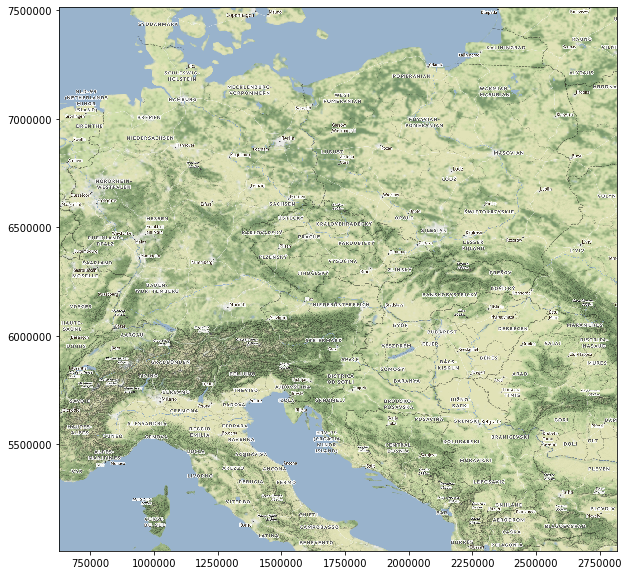

In [57]:
ZOOM_LEVEL = 8
w, s, e, n = 6, 43, 24, 54.5

# check number of tiles that will be downloaded
ctx.howmany(w, s, e, n, ZOOM_LEVEL, ll=True)

# download tiles
%time img, ext = ctx.bounds2img(w, s, e, n, ZOOM_LEVEL-1, ll=True)

# plot map 
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(img, extent=ext, aspect='auto')

## Loading data from PostGIS db


In [13]:
con = psycopg2.connect(database="skoda-postgres", user="root", password="sumpr0ject",
    host="localhost", port=35432)
sql = "SELECT * FROM rides LIMIT 100000;"
# sql = "SELECT * FROM rides WHERE carid IN ('524305','536208') AND recorddatetime BETWEEN '2019-05-10' AND '2019-05-11';"

df = GeoDataFrame.from_postgis(sql, con, geom_col='recordgeo' )

Let's see what the data looks like:

In [60]:
wgs84 = df.crs
df.head()
# df.dtypes

,carid,recorddatetime,recordgeo,geometry
t,,,,
2019-08-30 13:42:47,591603,2019-08-30 13:42:47,POINT (14.63016 50.13051),POINT (14.63016 50.13051)
2019-08-30 13:43:05,591603,2019-08-30 13:43:05,POINT (14.62411 50.12812),POINT (14.62411 50.12812)
2019-08-30 13:43:27,591603,2019-08-30 13:43:27,POINT (14.61750 50.12608),POINT (14.61750 50.12608)
2019-08-30 13:43:45,591603,2019-08-30 13:43:45,POINT (14.61139 50.12451),POINT (14.61139 50.12451)
2019-08-30 13:44:04,591603,2019-08-30 13:44:04,POINT (14.60463 50.12300),POINT (14.60463 50.12300)


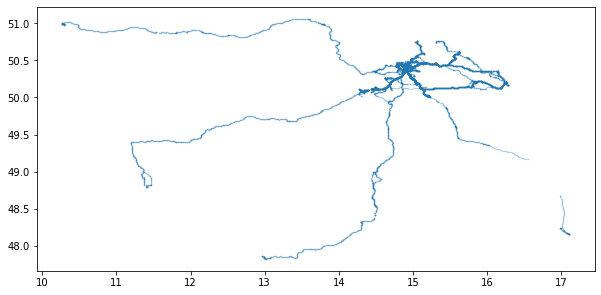

In [15]:
df.plot(markersize=0.1, alpha=0.2)

To convert the DataFrame to Trajectories we need to create a temporal index:

In [16]:
df['t'] = pd.to_datetime(df['recorddatetime'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('t')
df['carid']=df['carid'].astype(int)


If we look at the data distributions, we can see that there are a lot of records with speed over ground (SOG) values of zero in this dataframe:

2019-03-18 09:56:52
2019-09-13 14:19:26


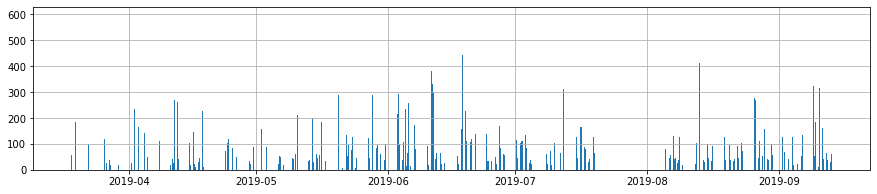

In [17]:
start_day = min(df['recorddatetime'])
end_day = max(df['recorddatetime'])
print(start_day)
print(end_day)
df['recorddatetime'].hist(bins=4000, figsize=(15,3))

Let's get rid of these rows with zero SOG:

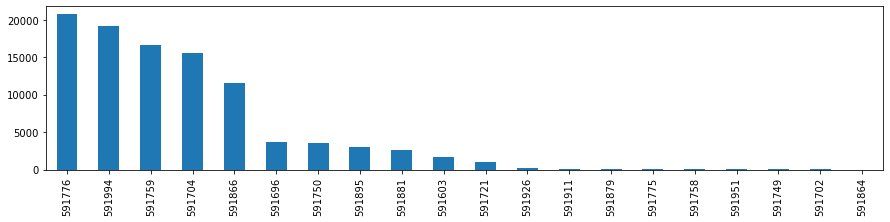

In [19]:
df['carid'].value_counts().plot(kind='bar', figsize=(15,3))


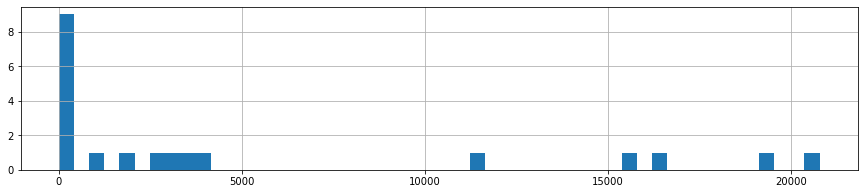

In [20]:


df['carid'].value_counts().hist(bins=50,figsize=(15,3))

Finally, let's create trajectories:

In [21]:
MIN_LENGTH = 100 # meters

t_start = datetime.now()
df['geometry'] = df['recordgeo']

trajectories = []
generalized_trajs = []
            
for key, values in df.groupby(['carid']):
    if len(values) < 2:
        continue
    trajectory = mp.Trajectory(key, values)
    if trajectory.get_length() < MIN_LENGTH:
        continue
#     print(trajectory)
    trajectories.append(trajectory)
    generalized_trajs.append(trajectory.generalize(mode='douglas-peucker', tolerance=0.001)) #(mode='min-time-delta', tolerance=timedelta(minutes=5))

print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished creating 20 trajectories in 0:00:21.630465


## Plotting trajectories

Let's give the most common ship types distinct colors. The remaining ones will be just grey:

In [22]:
def plot_vessel_trajectories(trajs):
    shiptype_to_color = {
        'Passenger': 'blue', 
        'HSC': 'green', 
        'Tanker': 'red',
        'Cargo': 'orange'}
    default_color = 'blue'

    ax = None
    for traj in trajs:
#         ship_type = traj.df['ShipType'].iloc[0]
        ship_type = None

        try:
            ship_color = shiptype_to_color[ship_type]
        except KeyError:
            ship_color = default_color

        if ax is None:
            ax = traj.plot(linewidth=1, capstyle='round', column='Name', legend=True, figsize=(12,9), color=ship_color)
        else:
            traj.plot(ax=ax, linewidth=1, capstyle='round', column='Name', legend=True, figsize=(12,9), color=ship_color) 

CPU times: user 13.5 s, sys: 2.39 s, total: 15.9 s
Wall time: 11.2 s


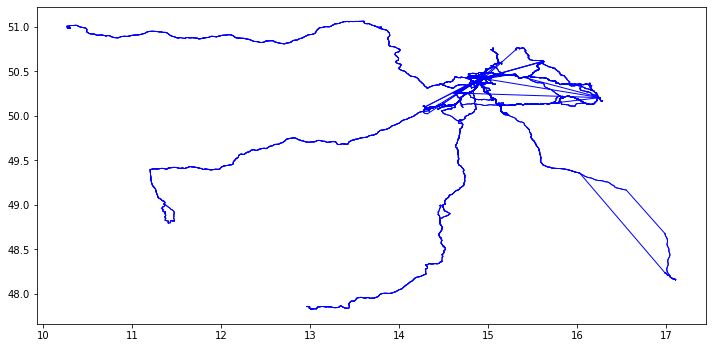

In [23]:
%%time
plot_vessel_trajectories(trajectories)

CPU times: user 3.67 s, sys: 1.44 s, total: 5.11 s
Wall time: 2.16 s


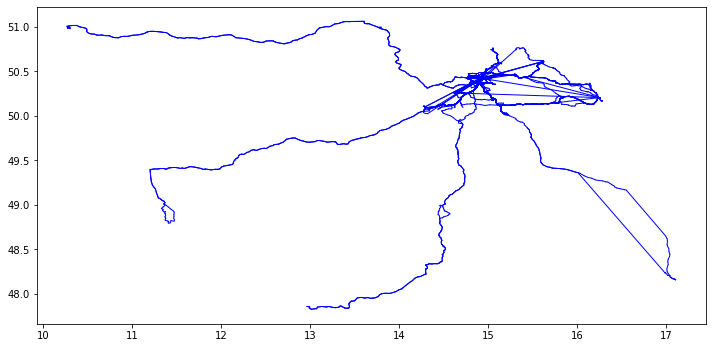

In [24]:
%%time
plot_vessel_trajectories(generalized_trajs)

## Visualizing trajectory properties

We can also plot individual trajectories to better visualize their properties, such as the changes in NavStatus:

In [25]:
my_traj = trajectories[0]
my_traj.df.head()

,carid,recorddatetime,recordgeo,geometry
t,,,,
2019-08-30 13:42:47,591603,2019-08-30 13:42:47,POINT (14.63016 50.13051),POINT (14.63016 50.13051)
2019-08-30 13:43:05,591603,2019-08-30 13:43:05,POINT (14.62411 50.12812),POINT (14.62411 50.12812)
2019-08-30 13:43:27,591603,2019-08-30 13:43:27,POINT (14.61750 50.12608),POINT (14.61750 50.12608)
2019-08-30 13:43:45,591603,2019-08-30 13:43:45,POINT (14.61139 50.12451),POINT (14.61139 50.12451)
2019-08-30 13:44:04,591603,2019-08-30 13:44:04,POINT (14.60463 50.12300),POINT (14.60463 50.12300)


In [26]:
my_traj.df.tail()

,carid,recorddatetime,recordgeo,geometry
t,,,,
2019-09-11 09:33:46,591603,2019-09-11 09:33:46,POINT (14.92201 50.42003),POINT (14.92201 50.42003)
2019-09-11 09:33:56,591603,2019-09-11 09:33:56,POINT (14.92383 50.41943),POINT (14.92383 50.41943)
2019-09-11 09:34:07,591603,2019-09-11 09:34:07,POINT (14.92523 50.41895),POINT (14.92523 50.41895)
2019-09-11 09:34:15,591603,2019-09-11 09:34:15,POINT (14.92514 50.41858),POINT (14.92514 50.41858)
2019-09-11 09:34:41,591603,2019-09-11 09:34:41,POINT (14.92521 50.41857),POINT (14.92521 50.41857)


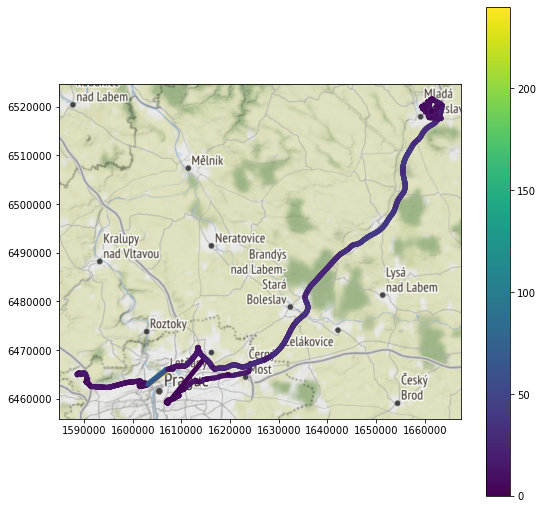

In [59]:
ZOOM_LEVEL = 10  # don't increase to ZOOM_LEVEL >= 15 because this causes a tile not found 404 error
my_traj.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', legend=True, 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Note: When plotting with basemap, you may run into missing map tiles. For Stamen, you can check map tile availability for a region and zoom level at http://maps.stamen.com/#terrain/15/57.6714/11.8120

Available tile sources are listed in https://github.com/darribas/contextily/blob/master/contextily/tile_providers.py, e.g.

```
ST_TONER = 'http://tile.stamen.com/toner/{z}/{x}/{y}.png'
ST_TONER_HYBRID = 'http://tile.stamen.com/toner-hybrid/{z}/{x}/{y}.png'
ST_TONER_LABELS = 'http://tile.stamen.com/toner-labels/{z}/{x}/{y}.png'
ST_TONER_LINES = 'http://tile.stamen.com/toner-lines/{z}/{x}/{y}.png'
ST_TONER_BACKGROUND = 'http://tile.stamen.com/toner-background/{z}/{x}/{y}.png'
ST_TONER_LITE = 'http://tile.stamen.com/toner-lite/{z}/{x}/{y}.png'

ST_TERRAIN = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
ST_TERRAIN_LABELS = 'http://tile.stamen.com/terrain-labels/{z}/{x}/{y}.png'
ST_TERRAIN_LINES = 'http://tile.stamen.com/terrain-lines/{z}/{x}/{y}.png'
ST_TERRAIN_BACKGROUND = 'http://tile.stamen.com/terrain-background/{z}/{x}/{y}.png'

ST_WATERCOLOR = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
```

More on plotting GeoPandas GeoDataframes: http://geopandas.org/gallery/plotting_basemap_background.html

## Finding ships passing under Älvsborgsbron bridge
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [35]:
area_of_interest = Polygon([(
              14.924583435058592,
              50.43126756156562),
            (
              14.918060302734375,
              50.420495471498114
            ),
            (
              14.938144683837889,
              50.413330948495485
            ),
            (
              14.941835403442383,
              50.42558107823979
            ),
            (
              14.924583435058592,
              50.43126756156562
            )])

In [36]:
intersections = []
for traj in trajectories:
    if traj.to_linestring().intersects(area_of_interest):
        intersections.append(traj)
print("Found {} intersections".format(len(intersections)))

Found 16 intersections


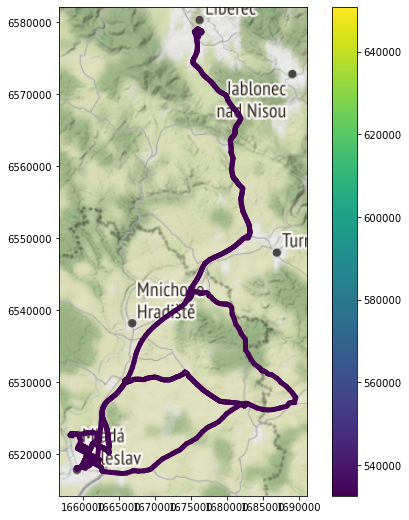

In [39]:
bridge_traj = intersections[3]
bridge_traj.plot(with_basemap=True, linewidth=5, capstyle='round', column='carid', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

In [40]:
bridge_traj.df.head()

,carid,recorddatetime,recordgeo,geometry
t,,,,
2019-05-21 07:13:12,591721,2019-05-21 07:13:12,POINT (14.92990 50.41776),POINT (14.92990 50.41776)
2019-05-21 07:13:41,591721,2019-05-21 07:13:41,POINT (14.92892 50.41811),POINT (14.92892 50.41811)
2019-05-21 07:13:46,591721,2019-05-21 07:13:46,POINT (14.92873 50.41809),POINT (14.92873 50.41809)
2019-05-21 07:14:06,591721,2019-05-21 07:14:06,POINT (14.92733 50.41845),POINT (14.92733 50.41845)
2019-05-21 07:14:18,591721,2019-05-21 07:14:18,POINT (14.92609 50.41883),POINT (14.92609 50.41883)


## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [41]:
trips = []
for traj in trajectories:
    for x in traj.split_by_observation_gap(timedelta(minutes=5)):
        if x.get_length() > MIN_LENGTH:
            trips.append(x)
print("Extracted {} individual trips from {} continuous vessel tracks".format(len(trips), len(trajectories)))

Extracted 2085 individual trips from 20 continuous vessel tracks


*Note: Splitting continous observations by observation gap is a straightforward way to extract individual trips. More sophisticated approaches require stop detection methods that do not require extended periods of time where the speed is at zero. MovingPandas so far does not implement such stop detection functions.*

Let's plot the resulting trips!

CPU times: user 9min 41s, sys: 3min 41s, total: 13min 22s
Wall time: 5min 48s


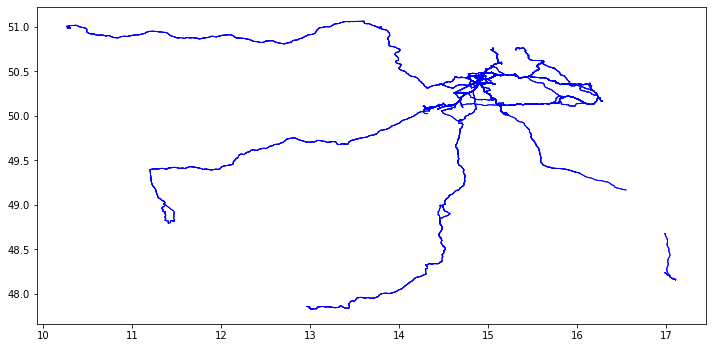

In [42]:
%%time
plot_vessel_trajectories(trips)

Compared to plotting the original continuous observations, this visualization is much cleaner because there are no artifacts at the border of the area of interest. 

Next, let's get the trip origins:

In [49]:
origins = []
for trip in trips:
    origins.append({'geometry': trip.get_start_location(), 'id': trip.id, 
                    'carid': trip.df.head(1)['carid'][0],'recorddatetime': trip.df.head(1)['recorddatetime'][0]})
origins = GeoDataFrame(pd.DataFrame(origins), crs=wgs84)

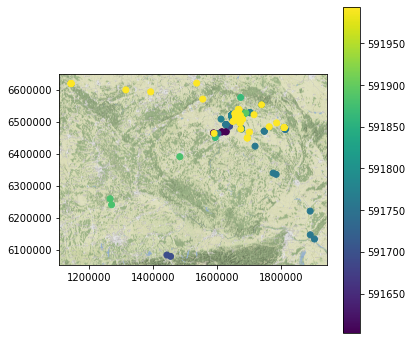

In [46]:
ax = origins.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(6,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

In our data sample, trip origins can be:
- When a ship departs its anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

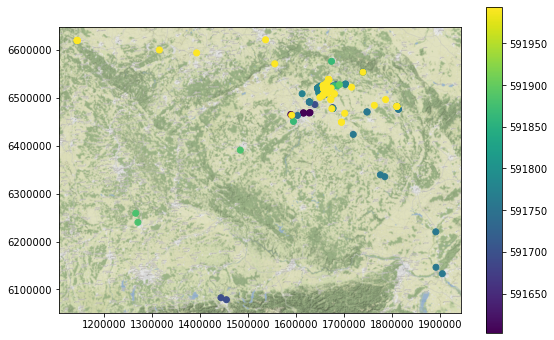

In [51]:
ax = origins.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(9,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

## Finding vehicles that depart from Karlovo namesti CTU

In [52]:
# karlovo namesti CVUT areal
area_of_interest = Polygon([(
              14.416846632957458,
              50.076604219275936
),
            (
              14.416674971580505,
              50.076490610564875
            ),
            (
              14.416835904121399,
              50.07602584485287
            ),
            (
              14.418354034423826,
              50.07610502747774
            ),
            (
              14.41826283931732,
              50.07671094236533
            ),
            (
              14.416846632957458,
              50.076604219275936
            )])

We can identify vessels that start their trip within a given area of interest by intersecting trip starting locations with our area of interest:

In [53]:
departures = []
for traj in trips:
    if traj.get_start_location().intersects(area_of_interest):
        departures.append(traj)
print("Found {} departures".format(len(departures)))

Found 0 departures


In [56]:
departures[1].plot(with_basemap=True, linewidth=5, capstyle='round', column='carid', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

IndexError: list index out of range

Let's see what kind of ships depart from here:

In [55]:
for traj in departures:
    print("{} vessel '{}' departed at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_start_time()))

Of course, the same works for arrivals:

In [54]:
arrivals = []
for traj in trips:
    if traj.get_end_location().intersects(area_of_interest):
        arrivals.append(traj)
print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("{} vessel '{}' arrived at {}".format(traj.df['carid'].iloc[0], traj.df['carid'].iloc[0], traj.get_end_time()))

Found 0 arrivals
